<a href="https://colab.research.google.com/github/juancuevas-ops/modelo-predictivo-de-ventas/blob/main/prediccion_ventas_juan_cuevas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#bueno para este analis debemos abrir un archivo csv,luego la primera columna con las fechas. 
#Esto es para que nos permita hacer filtrados por fecha directamente y algunas operaciones especiales.
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('fast')
 
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten
from sklearn.preprocessing import MinMaxScaler
 
dataframe = pd.read_csv('/content/ventas_prediccion.csv',  parse_dates=[0], header=None,index_col=0, squeeze=True,names=['fecha','unidades'])
dataframe.head()

fecha
2017-01-02    236
2017-01-03    237
2017-01-04    290
2017-01-05    221
2017-01-07    128
Name: unidades, dtype: int64

In [ ]:
dataframe

fecha
2017-01-02    236
2017-01-03    237
2017-01-04    290
2017-01-05    221
2017-01-07    128
             ... 
2018-11-26    276
2018-11-27    220
2018-11-28    183
2018-11-29    251
2018-11-30    189
Name: unidades, Length: 604, dtype: int64

In [ ]:
#aca podemos visualiar desde cuando son las fechas de ventas
print(dataframe.index.min())
print(dataframe.index.max())

2017-01-02 00:00:00
2018-11-30 00:00:00


In [ ]:

#Y ahora veamos cuantas muestras tenemos de cada año:
print(len(dataframe['2017']))
print(len(dataframe['2018']))

315
289


In [ ]:
#en 2018 nos falta el último mes… que será lo que trataremos de pronosticar.
#Visualización de datos estdistica,conteo,media etc...Son un total de 604 registros, la media de venta de 
#unidades es de 215 y un desvío de 75, es decir que por lo general 
#estaremos entre 140 y 290 unidades.
dataframe.describe()

count    604.000000
mean     215.935430
std       75.050304
min       51.000000
25%      171.000000
50%      214.000000
75%      261.250000
max      591.000000
Name: unidades, dtype: float64

saquemos los promedios mensuales:

In [ ]:


m_x =dataframe.resample('M').mean()
m_x

fecha
2017-01-31    203.923077
2017-02-28    184.666667
2017-03-31    182.964286
2017-04-30    198.960000
2017-05-31    201.185185
2017-06-30    209.518519
2017-07-31    278.923077
2017-08-31    316.000000
2017-09-30    222.925926
2017-10-31    207.851852
2017-11-30    185.925926
2017-12-31    213.200000
2018-01-31    201.384615
2018-02-28    190.625000
2018-03-31    174.846154
2018-04-30    186.000000
2018-05-31    190.666667
2018-06-30    196.037037
2018-07-31    289.500000
2018-08-31    309.038462
2018-09-30    230.518519
2018-10-31    209.444444
2018-11-30    184.481481
Freq: M, Name: unidades, dtype: float64

grafiquemos las medias mensuales

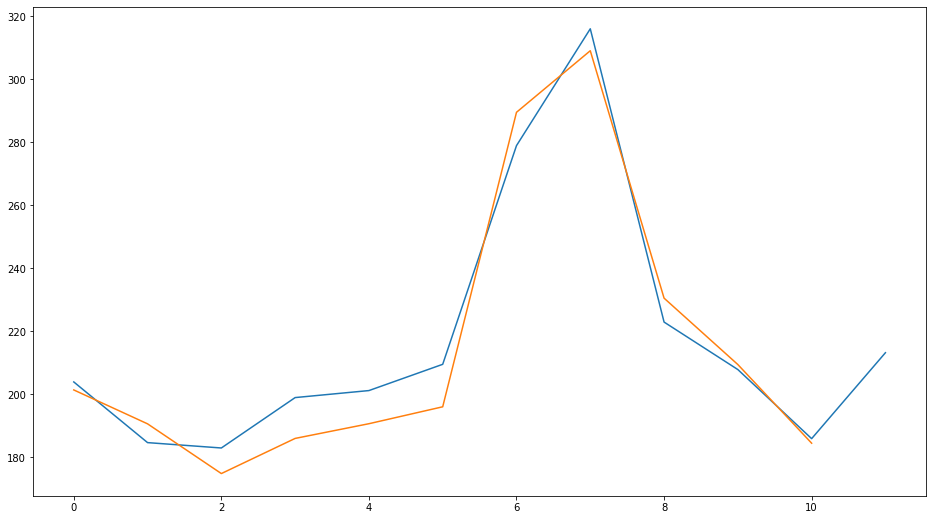

In [ ]:

plt.plot(m_x['2017'].values)
plt.plot(m_x['2018'].values)

Vemos que en 2017 (en azul) tenemos un inicio de año con un descenso en la cantidad de unidades, luego comienza a subir hasta la llegada del verano europeo en donde en los meses junio y julio tenemos la mayor cantidad de ventas. Finalmente vuelve a disminuir y tiene un pequeño pico en diciembre con la Navidad.

También vemos que 2018 (naranja) se comporta prácticamente igual. Es decir que pareciera que tenemos una estacionalidad. Por ejemplo podríamos aventurarnos a pronosticar que “el verano de 2019 también tendrá un pico de ventas”.

Veamos la gráfica de ventas diarias (en unidades) en junio y julio

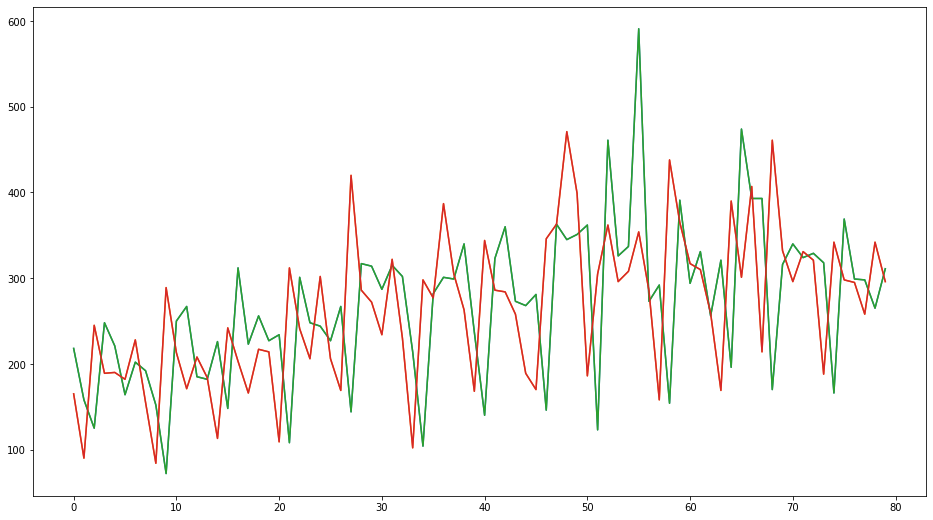

In [ ]:
v_2017 = dataframe['2017-06-01':'2017-09-01']
plt.plot(v_2017.values)
v_2018 = dataframe['2018-06-01':'2018-09-01']
plt.plot(v_2018.values)

v_2017 = df['2017-06-01':'2017-09-01']
plt.plot(v_2017.values)
v_2018 = df['2018-06-01':'2018-09-01']
plt.plot(v_2018.values)

Preparamos los datos
Este puede que sea uno de los pasos más importantes de este ejercicio.

Lo que haremos es alterar nuestro flujo de entrada del archivo csv que contiene una columna con las unidades despachadas, y lo convertiremos en varias columnas. ¿Y porqué hacer esto? En realidad lo que haremos es tomar nuestra serie temporal y la convertiremos en un “problema de tipo supervisado“ para poder alimentar nuestra red neuronal y poder entrenarla con backpropagation (“como es habitual”). Para hacerlo, debemos tener unas entradas y unas salidas para entrenar al modelo.

Lo que haremos -en este ejemplo- es tomar los 7 días previos para “obtener” el octavo. Podríamos intentar entrenar a la red con 2, ó 3 días. O también podríamos tener 1 sola salida, ó hasta “atrevernos” intentar predecir más de un “día futuro”. Eso lo dejo a ustedes cómo actividad extra. Pero entonces quedémonos con que:

Entradas: serán “7 columnas” que representan las ventas en unidades de los 7 días anteriores.
Salida: El valor del “8vo día”. Es decir, las ventas (en unids) de ese día.
Para hacer esta transformación usaré una función llamada series_to_supervised() creada y explicada en este blog. (La verás en el código, a continuación)

Antes de usar la función, utilizamos el MinMaxScaler para transformar el rango de nuestros valores entre -1 y 1 (pues sabemos que a nuestra red neuronal, le favorece para realizar los cálculos).

Entonces aqui vemos cómo queda nuestro set de datos de entrada.

In [ ]:
PASOS=7
 
# convertiremos serie temporales a aprendisaje supervisado
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# load dataset
values = df.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, PASOS, 1)
reframed.head()

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
7,-0.314815,-0.311111,-0.114815,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333
8,-0.311111,-0.114815,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407
9,-0.114815,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407,-0.522222
10,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407,-0.522222,-0.644444
11,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407,-0.522222,-0.644444,-0.344444


Usaremos como entradas las columnas encabezadas como var1(t-7) a (t-1) y nuestra salida (lo que sería el valor “Y” de la función) será el var1(t) -la última columna-.

Creamos la Red Neuronal Artificial
Antes de crear la red neuronal, subdividiremos nuestro conjunto de datos en train y en test. ATENCIÓN, algo importante de este procedimiento, a diferencia de en otros problemas en los que podemos “mezclar” los datos de entrada, es que en este caso nos importa mantener el orden en el que alimentaremos la red. Por lo tanto, haremos una subdivisión de los primeros 567 días consecutivos para entrenamiento de la red y los siguientes 30 para su validación. Esta es una proporción que elegí yo, y que me pareció conveniente, pero definitivamente, puede no ser la óptima (queda propuesto al lector, variar esta proporción por ejemplo a 80-20 y comparar resultados )

In [ ]:

# se dividen los datos en entrenamiento y validacion
values = reframed.values
n_train_days = 315+289 - (30+PASOS)
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# entrada y salida de datos
x_train, y_train = train[:, :-1], train[:, -1]
x_val, y_val = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(567, 1, 7) (567,) (30, 1, 7) (30,)


Hemos transformado la entrada en un arreglo con forma (567,1,7) esto al castellano significa algo así como “567 entradas con vectores de 1×7”.

La arquitectura de la red neuronal será:

Entrada 7 inputs, como dijimos antes
1 capa oculta con 7 neuronas (este valor lo escogí yo, pero se puede variar)
La salida será 1 sola neurona
Como función de activación utilizamos tangente hiperbólica puesto que utilizaremos valores entre -1 y 1.
Utilizaremos como optimizador Adam y métrica de pérdida (loss) Mean Absolute Error
Como la predicción será un valor continuo y no discreto, para calcular el Acuracy utilizaremos Mean Squared Error y para saber si mejora con el entrenamiento se debería ir reduciendo con las EPOCHS.

In [ ]:

def crear_modeloFF():
    model = Sequential() 
    model.add(Dense(PASOS, input_shape=(1,PASOS),activation='tanh'))
    model.add(Flatten())
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_absolute_error',optimizer='Adam',metrics=["mse"])
    model.summary()
    return model

Entrenamiento y Resultados
Veamos cómo se comporta nuestra máquina al cabo de 40 épocas.

In [ ]:

EPOCHS=40
 
model = crear_modeloFF()
 
history=model.fit(x_train,y_train,epochs=EPOCHS,validation_data=(x_val,y_val),batch_size=PASOS)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1, 7)              56        
_________________________________________________________________
flatten_2 (Flatten)          (None, 7)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 8         
Total params: 64
Trainable params: 64
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
81/81 [==============================] - 1s 4ms/step - loss: 0.2673 - mse: 0.1073 - val_loss: 0.1975 - val_mse: 0.0650
Epoch 2/40
81/81 [==============================] - 0s 1ms/step - loss: 0.2208 - mse: 0.0778 - val_loss: 0.1807 - val_mse: 0.0554
Epoch 3/40
81/81 [==============================] - 0s 1ms/step - loss: 0.2039 - mse: 0.0694 - val_loss: 0.1684 - val_mse: 0.050

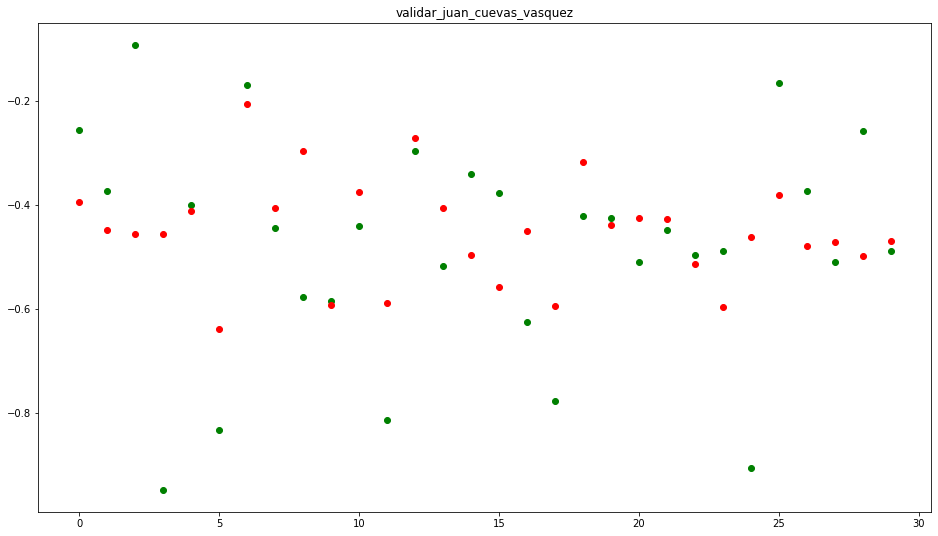

In [ ]:

results=model.predict(x_val)
plt.scatter(range(len(y_val)),y_val,c='g')
plt.scatter(range(len(results)),results,c='r')
plt.title('validar_juan_cuevas_vasquez')
plt.show()

En la gráfica vemos que los puntitos verdes intentan aproximarse a los rojos. Cuanto más cerca ó superpuestos mejor. TIP: Si aumentamos la cantidad de EPOCHS mejora cada vez más.
Veamos y comparemos también cómo disminuye el LOSS tanto en el conjunto de train como el de Validate, esto es bueno ya que indica que el modelo está aprendiendo. A su vez pareciera no haber overfitting, pues las curvas de train y validate son distintas.

